## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

# TensorFlow Baby
import tensorflow as tf

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(255,255,255,255)', plot_bgcolor='rgba(0,0,0,0.8)')

fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)

pio.templates['xgboost'] = templated_fig.layout.template
pio.templates.default = 'xgboost'


## SBG LOADER

In [2]:
def sbg_dloader(data_dir=str, start_date=int) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(data_dir))

    df.rename(columns={'Closing (c)': 'Close'}, inplace=True)
    df.rename(columns={'High (c)': 'High'}, inplace=True)
    df.rename(columns={'Low (c)': 'Low'}, inplace=True)

    # Date convert
    df['Date'] = pd.to_datetime(df['Date'])

    # Select date range
    df = df[(df['Date'].dt.year >= start_date)].copy()

    df.index = range(len(df))

    df = df.sort_values(by='Date')

    return pd.DataFrame(df)


## Decomposer

In [3]:
def sbg_decomposer(df=pd.DataFrame, feature=str, period=int):
    decompose_df = df[['Date', feature]].copy()
    decompose_df = decompose_df.set_index('Date')

    decompose = seasonal_decompose(decompose_df, period=period)

    return decompose


## SBG Technical Indicators

In [4]:
def moving_averages(df=pd.DataFrame, feature=str):
    df['EMA_9'] = df[feature].ewm(9).mean().shift()
    df['SMA_5'] = df[feature].rolling(5).mean().shift()
    df['SMA_10'] = df[feature].rolling(10).mean().shift()
    df['SMA_15'] = df[feature].rolling(15).mean().shift()
    df['SMA_30'] = df[feature].rolling(30).mean().shift()

    return df


## Relative Strength Index (RSI)

In [5]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi


## MACD

### Plotter

In [6]:
def plot_macd(df, ema_12, ema_26):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=ema_12, name='EMA 12'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=ema_26, name='EMA 26'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
    fig.show()


### Calculator

In [7]:
def macd(df=pd.DataFrame):
    ema_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    ema_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())

    df['MACD'] = pd.Series(ema_12 - ema_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

    # plot_macd(df, ema_12, ema_26)

    return ema_12, ema_26


## SBG Splitter

In [8]:
def sbg_splitter(df=pd.DataFrame, test_size=float, valid_size=float):
    test_split_idx  = int(df.shape[0] * (1-test_size))
    valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

    train_df = df.loc[:valid_split_idx].copy()
    valid_df = df.loc[valid_split_idx+1:test_split_idx].copy()
    test_df  = df.loc[test_split_idx+1:].copy()



    return train_df, valid_df, test_df


## SBG Preproceser

In [9]:
def sbg_dropper(train_df=pd.DataFrame, valid_df=pd.DataFrame, test_df=pd.DataFrame, columns=list):
    train_df = train_df.drop(columns, axis=1)
    valid_df = valid_df.drop(columns, axis=1)
    test_df  = test_df.drop(columns, axis=1)

    return train_df, valid_df, test_df


## SBG Fitter

### Model Loader

In [10]:
def model_loader(model_dir):
    return tf.keras.models.load_model(os.path.join(model_dir))


### Model Train

In [11]:
def model_train(train_df=pd.DataFrame, valid_df=pd.DataFrame, target=str, epochs=50, batch=34):
    y_train = train_df[target].copy()
    X_train = train_df.drop([target], axis=1)

    y_valid = valid_df[target].copy()
    X_valid = valid_df.drop([target], axis=1)

    nn_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(34, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    nn_model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())

    # Train the model
    nn_model.fit(
        X_train, 
        y_train,
        epochs=epochs, 
        batch_size=batch,
        validation_data=(X_valid, y_valid)
    )

    return nn_model


### Model Predict

In [12]:
def model_predict(test_set=pd.DataFrame, test_df=pd.DataFrame, target=str, trained_model=any):
    y_test  = test_df[target].copy()
    X_test  = test_df.drop([target], axis=1)

    y_pred = trained_model.predict(X_test)

    # # Reshape y_pred to be 1D if it has an extra dimension
    # y_pred_plot = y_pred.reshape(-1)

    # plt.figure(figsize=(12, 6))
    # plt.plot(test_set.Date, y_test, label='Actual')
    # plt.plot(test_set.Date, y_pred_plot, label='Predicted')
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.title('Actual vs Predicted')
    # plt.legend()
    # plt.show()

    return y_pred


## >> Test Space <<

#### Data Loader

In [13]:
# Load in dataset
data_dir = r'../data/csv/bidcorp.csv'
df = sbg_dloader(data_dir, 2020)
df1 = df.copy()


#### Decomposer

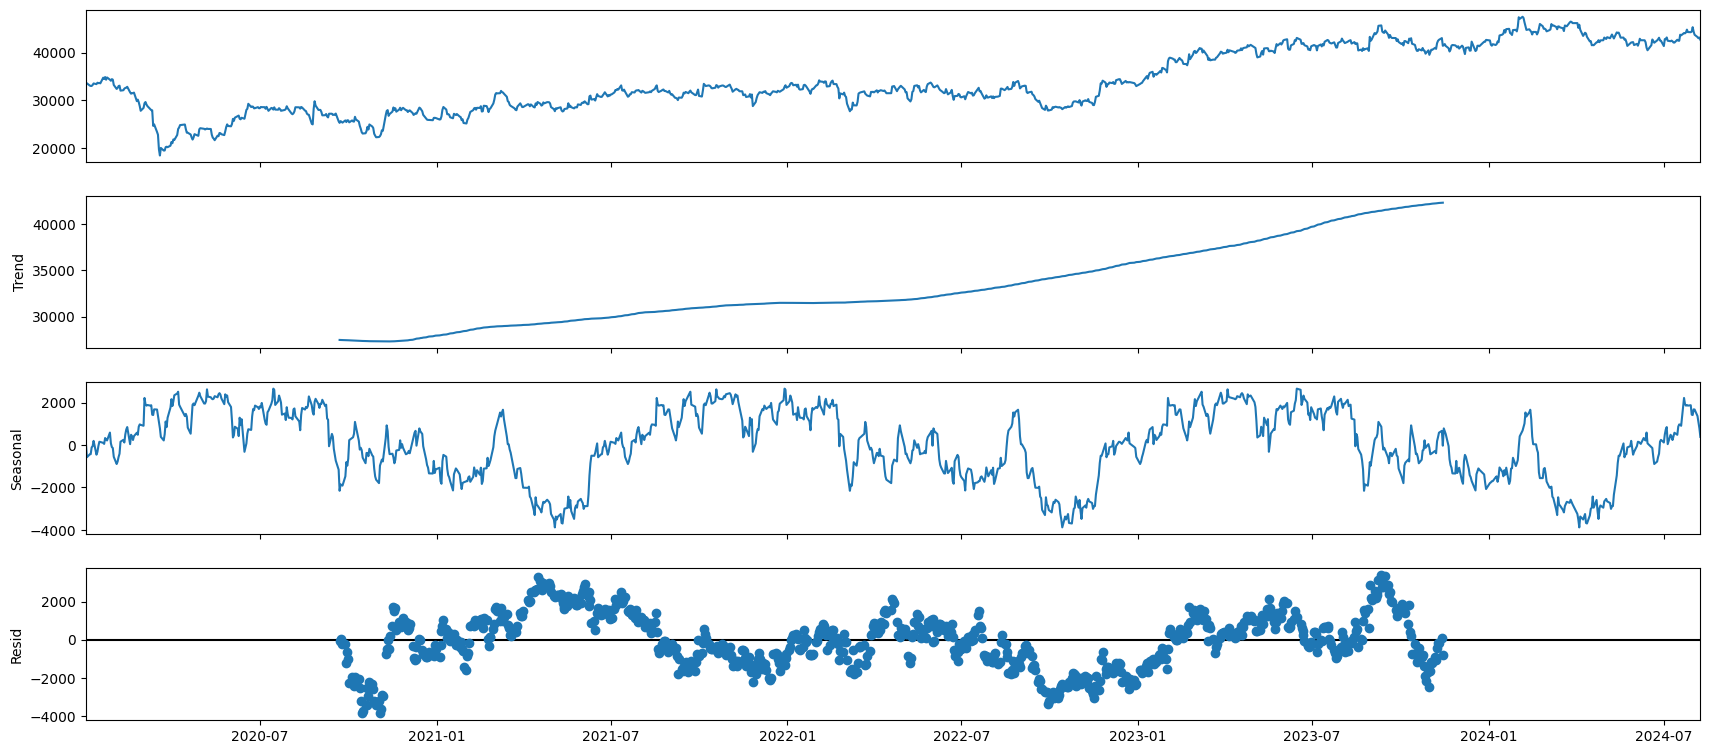

In [14]:
target = 'Close'
decompose = sbg_decomposer(df, target, 365)

fig = decompose.plot()
fig.set_size_inches(20, 8)


#### Technical Indicators (MA)

In [15]:
df = moving_averages(df, target)


#### Technical Indicators (RSI)

In [16]:
df['RSI'] = relative_strength_idx(df)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()


#### Technical Indicators (MACD)

In [17]:
ema_12, ema_26 = macd(df)


#### Boilerplate

In [18]:
df['Close'] = df['Close'].shift(-1)
df

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
1151,2020-01-02,33582.0,33834,32963,350978,2897,"117,420,295",1.37%,1.5296,4.0048,24.9697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1150,2020-01-03,33101.0,33749,32501,517404,3388,"172,730,306",0.33%,1.5246,3.9917,25.0518,33472.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1149,2020-01-06,33018.0,33500,32798,311032,1895,"102,798,859",-1.43%,1.5467,4.0497,24.6930,33529.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1148,2020-01-07,33017.0,33393,32917,347111,3002,"114,918,705",-0.25%,1.5506,4.0599,24.6311,33371.630996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,2020-01-08,33224.0,33550,32512,249979,1910,"82,185,681",0.00%,1.5507,4.0600,24.6303,33268.801396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-08-02,43264.0,44943,43742,537747,6362,"236,568,075",-1.45%,1.8746,5.1748,19.3240,43784.230577,44543.2,44352.8,43803.466667,43157.666667,58.565802,513.398435,470.589155
3,2024-08-05,43011.0,43640,42552,516242,6469,"222,540,998",-1.09%,1.8953,5.2320,19.1129,43780.007519,44430.0,44365.0,43913.533333,43213.366667,55.975533,410.748740,458.621072
2,2024-08-06,43164.0,43569,42527,644856,10656,"277,224,180",-0.58%,1.9064,5.2628,19.0011,43728.406767,44227.2,44281.4,43951.266667,43237.066667,53.993949,305.461956,427.989249
1,2024-08-07,42700.0,43642,42848,854119,5323,"369,515,828",0.36%,1.8997,5.2441,19.0687,43656.666091,43947.0,44178.0,43985.200000,43244.200000,44.668850,231.696391,388.730677


In [19]:
df = df.iloc[33:]
df = df[:-1]

df.index = range(len(df))


### Splitter

In [20]:
train_set, valid_set, test_set = sbg_splitter(df, .15, .15)
test_set

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
951,2023-12-05,40455.0,42000,40655,614510,4282,"253,110,545",-0.54%,1.8236,5.0511,19.7973,41274.916365,41214.8,41147.3,41237.533333,41115.733333,47.190796,-48.714684,-55.583101
952,2023-12-06,39700.0,41437,40365,1026640,9339,"417,967,391",-1.89%,1.8588,5.1486,19.4224,41271.024729,41194.4,41247.2,41224.200000,41124.666667,38.339438,-108.993856,-66.265252
953,2023-12-07,40995.0,40760,39488,1127546,6341,"449,757,014",-1.87%,1.8942,5.2465,19.0599,41189.422256,41065.4,41232.7,41152.600000,41123.866667,36.020977,-215.206952,-96.053592
954,2023-12-08,41100.0,41268,39496,763394,7901,"311,696,368",3.26%,1.8343,5.0808,19.6816,41040.480030,40740.0,41058.1,41013.133333,41100.266667,50.491472,-192.664997,-115.375873
955,2023-12-11,40420.0,41437,40700,655163,7759,"269,213,261",0.26%,1.8296,5.0678,19.7321,41035.932027,40769.0,40997.7,40985.733333,41140.733333,56.813517,-164.432240,-125.187147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,2024-08-01,43742.0,45621,44375,381312,5656,"170,141,911",-2.08%,1.8473,5.0996,19.6090,43717.256197,44628.6,44289.1,43652.266667,43093.133333,68.956407,588.280068,459.886835
1114,2024-08-02,43264.0,44943,43742,537747,6362,"236,568,075",-1.45%,1.8746,5.1748,19.3240,43784.230577,44543.2,44352.8,43803.466667,43157.666667,58.565802,513.398435,470.589155
1115,2024-08-05,43011.0,43640,42552,516242,6469,"222,540,998",-1.09%,1.8953,5.2320,19.1129,43780.007519,44430.0,44365.0,43913.533333,43213.366667,55.975533,410.748740,458.621072
1116,2024-08-06,43164.0,43569,42527,644856,10656,"277,224,180",-0.58%,1.9064,5.2628,19.0011,43728.406767,44227.2,44281.4,43951.266667,43237.066667,53.993949,305.461956,427.989249


### Dropper

In [21]:
drop_cols = ['Date', 'Volume', 'Low', 'High', '# Deals','Value (R)', 'Move (%)', 'DY', 'EY', 'PE']

train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)


### Fitter

In [22]:
model = model_train(
    train_df=train_df,
    valid_df=valid_df,
    target=target,
    epochs=85
).save('test_model.keras')
df


Epoch 1/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 23896.0469 - val_loss: 5949.2783
Epoch 2/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2745.1614 - val_loss: 910.8723
Epoch 3/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1118.0824 - val_loss: 798.3090
Epoch 4/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1013.2928 - val_loss: 827.6495
Epoch 5/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 954.5869 - val_loss: 788.0655
Epoch 6/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 855.8649 - val_loss: 783.8113
Epoch 7/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 918.6786 - val_loss: 1032.1077
Epoch 8/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 921.5924 - val_loss: 880.8430
Epoch 9/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 934.8150 - val_loss: 792.6085
Epoch 10/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 887.0713 - val_loss: 1051.5482
Epoch 11/85
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1059.3452 - val_loss: 1376.8082
Epoch 12/85
24/24 ━

,Date,Close,High,Low,Volume,# Deals,Value (R),Move (%),DY,EY,PE,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-18,31508.0,32302,31143,1052132,6544,"333,018,342",-0.91%,1.6306,4.2693,23.4226,32916.014042,32445.4,32504.0,32903.200000,33394.033333,24.709206,-431.188905,-345.431297
1,2020-02-19,31510.0,31671,31014,936551,5006,"293,732,932",0.35%,1.6249,4.2544,23.5046,32759.869824,32235.0,32385.0,32722.666667,33340.033333,26.493033,-470.087851,-373.361601
2,2020-02-20,31627.0,31576,31009,1389946,3819,"437,635,626",0.01%,1.6756,4.3548,22.9631,32631.468764,32017.8,32236.7,32527.066667,33289.733333,32.546306,-494.952414,-399.964976
3,2020-02-21,29835.0,31627,30888,2084573,7525,"651,501,744",0.37%,1.6694,4.3386,23.0483,32516.737168,31789.4,32080.2,32338.266667,33232.600000,40.876608,-499.874700,-421.421395
4,2020-02-24,30150.0,31400,29501,2021451,11077,"606,070,307",-5.67%,1.7697,4.5992,21.7424,32425.922125,31545.6,32038.8,32231.733333,33168.933333,26.246764,-633.884150,-466.385895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,2024-08-01,43742.0,45621,44375,381312,5656,"170,141,911",-2.08%,1.8473,5.0996,19.6090,43717.256197,44628.6,44289.1,43652.266667,43093.133333,68.956407,588.280068,459.886835
1114,2024-08-02,43264.0,44943,43742,537747,6362,"236,568,075",-1.45%,1.8746,5.1748,19.3240,43784.230577,44543.2,44352.8,43803.466667,43157.666667,58.565802,513.398435,470.589155
1115,2024-08-05,43011.0,43640,42552,516242,6469,"222,540,998",-1.09%,1.8953,5.2320,19.1129,43780.007519,44430.0,44365.0,43913.533333,43213.366667,55.975533,410.748740,458.621072
1116,2024-08-06,43164.0,43569,42527,644856,10656,"277,224,180",-0.58%,1.9064,5.2628,19.0011,43728.406767,44227.2,44281.4,43951.266667,43237.066667,53.993949,305.461956,427.989249


### Forecaster

In [23]:
loaded_model = model_loader('test_model.keras')


In [24]:
y_pred = model_predict(test_set, test_df, target, loaded_model)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [25]:
from datetime import datetime, timedelta
import pandas as pd

# train_set, valid_set, test_set = sbg_splitter(df, .15, .15)

drop_cols = ['Date']

# train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)

loaded_model = model_loader('test_model.keras')

start_date = datetime(2023, 8, 8)
end_date = datetime(2023, 8, 13)

# Set the current_date to the start_date
current_date = start_date
forecasted_df = df.copy()

new_row = pd.DataFrame([{
    'Date': pd.to_datetime(current_date).strftime('%Y-%m-%d 00:00:00'),
    'Close': y_pred[0,0]
}])

forecasted_df = pd.concat([forecasted_df, new_row], ignore_index=True)

forecasted_values = pd.DataFrame()

# Loop through the dates from start_date to end_date
while current_date <= end_date:
    # Apply moving averages and other indicators to forecasted_df
    forecasted_df = moving_averages(forecasted_df, target)
    
    forecasted_df['RSI'] = relative_strength_idx(forecasted_df)
    
    ema_12, ema_26 = macd(forecasted_df)
    
    forecasted_df['Close'] = forecasted_df['Close'].shift(-1)
    
    forecasted_df = forecasted_df.iloc[33:]
    forecasted_df = forecasted_df[:-1]

    forecasted_df.index = range(len(forecasted_df))

    train_set, valid_set, test_set = sbg_splitter(forecasted_df, .15, .15)

    # Drop unnecessary columns after appending the new row
    drop_cols = ['Date', 'Volume', 'Low', 'High', '# Deals','Value (R)', 'Move (%)', 'DY', 'EY', 'PE']

    train_df, valid_df, test_df = sbg_dropper(train_set, valid_set, test_set, drop_cols)
    
    model = model_train(
        train_df=train_df,
        valid_df=valid_df,
        target=target,
        epochs=85
    )

    y_pred = model_predict(test_set, test_df, target, model)

    new_row = pd.DataFrame([{
        'Date': pd.to_datetime(current_date).strftime('%Y-%m-%d 00:00:00'),
        'Close': y_pred[0,0]
    }])

    forecasted_values = pd.concat([forecasted_values, new_row], ignore_index=True)

    # forecasted_df = pd.concat([forecasted_df, forecasted_values], ignore_index=True)

    # Increment the current date
    current_date += timedelta(days=1)


Epoch 1/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 23379.0078 - val_loss: 5603.8418
Epoch 2/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2519.9644 - val_loss: 1595.0034
Epoch 3/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 950.8566 - val_loss: 775.7552
Epoch 4/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 768.5989 - val_loss: 790.5396
Epoch 5/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 824.9597 - val_loss: 773.2102
Epoch 6/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 839.2130 - val_loss: 832.9131
Epoch 7/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 840.0564 - val_loss: 768.9425
Epoch 8/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 854.8508 - val_loss: 756.6091
Epoch 9/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 794.1982 - val_loss: 809.7374
Epoch 10/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 770.8745 - val_loss: 749.1577
Epoch 11/85
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 776.1143 - val_loss: 751.1687
Epoch 12/85
23/23 ━━━━━━

In [26]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=forecasted_values.Date, y=forecasted_values.Close, name='Close'), row=1, col=1)
fig.show()